Enter in order: temperature, fuel source, moderator, core radius, fuel density, enrichment, initial neutron density, time taken:  300 U-235 heavy 500 10.6 0.175 100000 0.01


Calculated thermal output, in Joules, from time 0 to time 0.01 s : 79605.633 J


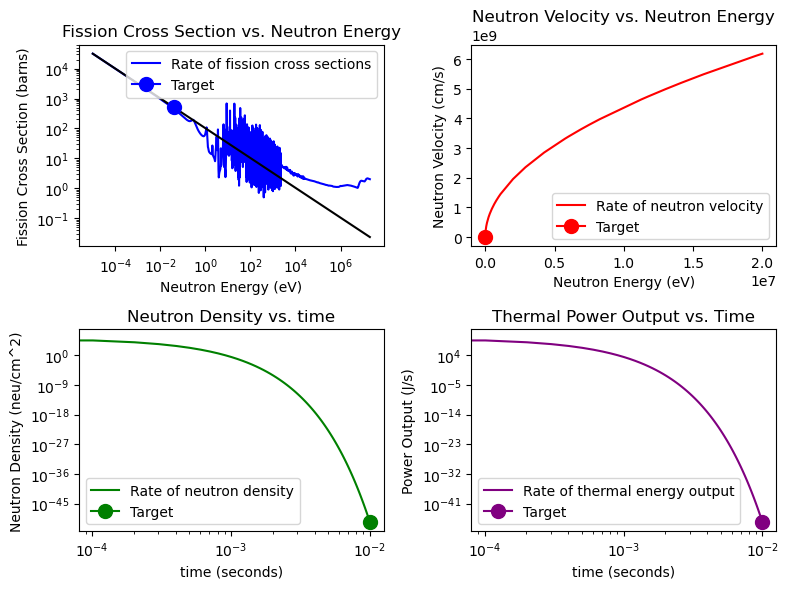

In [4]:
# - Imported data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy import units as u
from astropy import constants as const
from scipy.optimize import curve_fit
from scipy.integrate import simpson

# - Experimental Data taken from National Nuclear Data Center
df_U235fission = pd.read_csv("u235_fission.csv")
df_U235abs = pd.read_csv("u235_abs.csv")
df_U238abs = pd.read_csv("u238_abs.csv")

df_Pu239fission = pd.read_csv("pu239_fission.csv")
df_Pu239abs = pd.read_csv("pu239_abs.csv")
df_Pu240abs = pd.read_csv("pu240_abs.csv")

# - Adding a name to each main column index
df_U235fission.index.name = "Uranium 235 Fission"
df_U235abs.index.name = "Uranium 235 Absorption"
df_U238abs.index.name = "Uranium 238 Absorption"

df_Pu239fission.index.name = "Plutonium 239 Fission"
df_Pu239abs.index.name = "Plutonium 239 Absorption"
df_Pu240abs.index.name = "Plutornium 240 Absorption"

# - Main input string, asking for all parameters needed for further calculations.
# - temp = temperature of the moderator around a thermal reactor
# - fuel = the type of nuclear fuel that makes up most of the core. Here, it was limited to uranium and plutonium.
# - moderator = the element used to cool the core and distribute energy. Here, it was limited to heavy water and light water, some of the most common moderators.
# - radius = the radius of the sphereical thermal core (assumed in program that reactor core is a sphere)
# - fuelDen = the density, in gram per cm^3, of the fuel source
# - enrich = the enrichment percent of the fuel source, or what percent of said fuel source is actually fissile.
# - initialNeuDen = The initial neutron density of the core, something that can change for time in some reactors (and will here for the program)
# - time = the time from which fission begins

input_str = input("Enter in order: temperature, fuel source, moderator, core radius, fuel density, enrichment, initial neutron density, time taken: ")
temp, fuel, moderator, radius, fuelDen, enrich, initialNeuDen, time = input_str.split()

# - Turning all inputs that need to be floats into floats
temp = float(temp) * u.K 
radius = float(radius) * u.cm
fuelDen = float(fuelDen) * u.g / (u.cm ** 3)
enrich = float(enrich)
initialNeuDen = float(initialNeuDen) * (1/ u.cm**3)
time = float(time) * u.s

# Because most thermal cores are not purely the fission and fertile fuels, only a fraction of the fuel density is to be used. 
# On average, that fraction is 0.88, so fuel density is multiplied by 0.88
fuelDen = fuelDen * 0.88

# - Stating constants that will be used in calculations later
kB = ((8.617) * (10 ** -5)) * u.eV / u.K # Boltzman Constant
Na = (const.N_A) # Avogrado's Number
neutronMass = (const.m_n) # The mass of a neutron

# - Determining which fuel source is being used, so the correct data frame for the correct fuel is used
# - Depending on the fuel source, different data frames are created for the three main types: 
# - the fissile material's neutron fission cross section,
# - the fissile material's neutron absorption cross section,
# - the fertile material's neutron absorption cross section (fertile materials aren't able to be used in fission)
if (fuel == "U-235" or fuel == "Uranium-235" or fuel == "uranium-235"):
    used_df_fission = df_U235fission
    xFisFis = u.Quantity(used_df_fission["Energy_eV"], u.eV)
    yFisFis = u.Quantity(used_df_fission["CrossSection_barns"], u.barn)

    used_df_abs_fission = df_U235abs
    xAbsFis = u.Quantity(used_df_abs_fission["Energy_eV"], u.eV)
    yAbsFis = u.Quantity(used_df_abs_fission["CrossSection_barns"], u.barn)

    used_df_abs_fertile = df_U238abs
    xAbsFer = u.Quantity(used_df_abs_fertile["Energy_eV"], u.eV)
    yAbsFer = u.Quantity(used_df_abs_fertile["CrossSection_barns"], u.barn)

    # - These are the constant fissile properties that are dependent on which fuel is being used.
    enPerFiss = 205 * u.MeV # Taken from source: https://www-pub.iaea.org/MTCD/Publications/PDF/IAEA-THPH_web.pdf
    atomicMassFrac = 235 * u.g / u.mol
    atomicMassRest = 238 * u.g / u.mol

    # - Averages taken for the neutron scattering cross section of fissile materials and fertile materials
    fissionScatter = 15 * ((10**-24) * u.cm**2)
    fertileScatter = 10.5 * ((10**-24) * u.cm**2)
    
    
if (fuel == "Pu-239" or fuel == "Plutonium-239" or fuel == "plutonium-239"):
    used_df_fission = df_Pu239fission
    xFisFis = u.Quantity(used_df_fission["Energy_eV"], u.eV)
    yFisFis = u.Quantity(used_df_fissionn["CrossSection_barns"], u.barn)

    used_df_abs_fission = df_Pu239abs
    xAbsFis = u.Quantity(used_df_abs_fission["Energy_eV"], u.eV)
    yAbsFis = u.Quantity(used_df_abs_fission["CrossSection_barns"], u.barn)

    used_df_abs_fertile = df_Pu240abs
    xAbsFer = u.Quantity(used_df_abs_fertile["Energy_eV"], u.eV)
    yAbsFer = u.Quantity(used_df_abs_fertile["CrossSection_barns"], u.barn)
    
    enPerFiss = 180 * u.MeV # Taken from source: https://www.shaalaa.com/question-bank-solutions/the-fission-properties-of-_94-239-pu-are-very-similar-to-those-of-_92-235-u-the-average-energy-released-per-fission-is-180-mev_11668
    atomicMassFrac = 239 * u.g / u.mol
    atomicMassRest = 240 * u.g / u.mol
    fissionScatter = 7.968 * ((10**-24) * u.cm**2)
    fertileScatter = 24.6 * ((10**-24) * u.cm**2)
    

#Finding what fraction of the fuel's density is split between the fissile (easier for fission) material and the fertile (harder for fission) material
fuelDenFrac = enrich * fuelDen
fuelDenRest = (1 - enrich) * fuelDen
#Turning those densities from values in terms of grams to in terms of atoms
numDenFrac = ((fuelDenFrac * Na) / atomicMassFrac).to(1/u.cm**3)
numDenRest = ((fuelDenRest * Na) / atomicMassRest).to(1/u.cm**3)

# - Determining which constants (and averages for some values) should be used depending on the moderator (what goes around the nuclear core to help cool it)
if (moderator == "heavy" or moderator == "heavy_water"):
    moderator_abs = (5.19 * (10 ** -4)) * (10**-24) * u.cm**2
    modDen = 1.1 * u.g / (u.cm ** 3)
    modAtomicMass = 20 * u.g / u.mol
    modScatter = 4 * ((10**-24) * u.cm**2)

if (moderator == "light" or moderator == "light_water"):
    moderator_abs = 0.33 * (10**-24) * u.cm**2
    modDen = 1 * u.g / (u.cm ** 3)
    modScatter = 20 * ((10**-24) * u.cm**2)
    modAtomicMass = 18 * u.g / u.mol

# - Neutron number density of moderator
# - This is the density of the moderator in terms of neutrons per cm^3.
numDenMod = ((modDen * Na) / modAtomicMass).to(1/u.cm**3)

# - Finding the target neutron energy, the average energy stored within each neutron of the fuel core
# - By the physical properties of neutrons in thermal reactors, nuetron energy = 1.5 (Boltzmann Constant) (Temperature of moderator in Kelvin)

NeutronEn = (1.5)*(kB)*(temp)

targetNeutronEn = NeutronEn.to(u.eV)
valueNeutronEn = targetNeutronEn.to_value(u.eV)

xFisFisFit = xFisFis.to(u.eV).value
yFisFisFit = yFisFis.to(u.barn).value

xAbsFisFit = xAbsFis.to(u.eV).value
yAbsFisFit = yAbsFis.to(u.barn).value

xAbsFerFit = xAbsFer.to(u.eV).value
yAbsFerFit = yAbsFer.to(u.barn).value



# Function for curve fit

def model (x, A, k):
    return A * (x ** k)

# Three separate plots for the three main data frames that I am taking data from (The last two will not be displayed as part of output)
# The main point of these plots is to create a fit line to go with each data frame, to help find the value of cross section for any neutron energy that is
# not specifically a part of the data frame.
p0 = [1,1]
poptFisFis, pcov = curve_fit(model, xFisFisFit, yFisFisFit, p0 = p0)
A_fit, k_fit = poptFisFis
fit_lineFisFis = model(xFisFis, A_fit, k_fit) * u.barn

poptAbsFis, pcov = curve_fit(model, xAbsFisFit, yAbsFisFit, p0 = p0)
B_fit, m_fit = poptAbsFis
fit_lineAbsFis = model(xAbsFis, B_fit, m_fit) * u.barn

poptAbsFer, pcov = curve_fit(model, xAbsFerFit, yAbsFerFit, p0 = p0)
C_fit, n_fit = poptAbsFer
fit_lineAbsFer = model(xAbsFer, C_fit, n_fit) * u.barn


# - Functions to match a point of neutron energy with a corresponding type of cross section
def getFissionFissionCS(used_df_fission, valueNeutronEn):
    match = used_df_fission.loc[used_df_fission["Energy_eV"] == valueNeutronEn, "CrossSection_barns"]

    if not match.empty:
        return match.iloc[0]
    else:
        return model(valueNeutronEn, A_fit, k_fit)

def getAbsFissionCS(used_df_abs_fission, valueNeutronEn):
    match = used_df_abs_fission.loc[used_df_abs_fission["Energy_eV"] == valueNeutronEn, "CrossSection_barns"]
    
    if not match.empty:
        return match.iloc[0]
    else:
        return model(valueNeutronEn, B_fit, m_fit)

def getAbsFertileCS(used_df_abs_fertile, valueNeutronEn):
    match = used_df_abs_fertile.loc[used_df_abs_fertile["Energy_eV"] == valueNeutronEn, "CrossSection_barns"]
    if not match.empty:
        return match.iloc[0]
    else:
        return model(valueNeutronEn, C_fit, n_fit)


# - Using the functions to get the values that matter, the target cross sections and their sums (used in later math):

targetFissionFissionCS = getFissionFissionCS(used_df_fission, valueNeutronEn) * ((10**-24) * u.cm**2)
targetFissionFissionCS_inBarns = getFissionFissionCS(used_df_fission, valueNeutronEn)
targetAbsFissionCS = getAbsFissionCS(used_df_abs_fission, valueNeutronEn) * ((10**-24) * u.cm**2)
targetAbsFertileCS = getAbsFertileCS(used_df_abs_fertile, valueNeutronEn) * ((10**-24) * u.cm**2)

sumMacroFisCS = (targetFissionFissionCS * numDenFrac)
sumMacroAbsCS = (targetAbsFissionCS * numDenFrac) + (targetAbsFertileCS * numDenRest) + (numDenMod * moderator_abs)
sumMacroScatCS = (numDenFrac * fissionScatter) + (numDenRest * fertileScatter) + (numDenMod * modScatter)

# - The heavy water moderator comes with a 33% decrease in cross section due to its higher weight causing less movement (The 33% is a rough average used in common calculations)

if (moderator == "heavy" or moderator == "heavy_water"):
    meanCos = 0.33
    sumMacroScatCS = sumMacroScatCS * (1 - meanCos)

sumMacroTotCS = (sumMacroFisCS + sumMacroAbsCS + sumMacroScatCS).to(1/u.cm)

# - The actual math:

# Target Neutron Energy = Neutron Kinetic Energy = 0.5(neutron mass)((neutron velocity)^2)
# Reversing this formula gives you the average neutron velocity within the core
# I'm also getting the velocity as a function of time
neutronVel = np.sqrt((2 * (targetNeutronEn.to(u.J))) / (neutronMass))
neutronVelPerTime = np.sqrt((2 * (xFisFis.to(u.J))) / (neutronMass))


neutronVel = neutronVel.to(u.cm / u.s)
neutronVelPerTime = neutronVelPerTime.to(u.cm / u.s)


# Later constants that require some math with the inputs
# Formula for diffusion, the overall movement of neutrons from higher concentration to lower concentration during flux
# D = (neutron velocity) / (3 * (Sum of all types of cross sections done by every type of neutron in the thermal reactor on a macroscopic level))
diffusionD = (neutronVel) / (3 * sumMacroTotCS)

# Formula for neutron leakage: B^2 = (pi/radius)*2 (For spheroid core)
B_squared = ((np.pi / radius)**2).to(1/ u.cm**2)

# The major formula depicting the net production rate of neutrons within a reactor
# --------- Production Rate ------------------Loss Rate ---------------------leakage variable
superEq = ((neutronVel * sumMacroFisCS) - (neutronVel * sumMacroAbsCS) - (diffusionD * B_squared))


time_scale = np.linspace(0, time, num = 100)

# Creating the neutron density equation as a exponential equation (closest form fitting, I believe)
NeutronDensityEquation = initialNeuDen * (np.exp(superEq * time_scale).to(u.dimensionless_unscaled).value)
targetNeutronDensity = initialNeuDen * (np.exp(superEq * time))

#Value of spheroid
volume = ((4/3) * (np.pi) * ((radius)**3)).to(u.cm**3)

# Fission rate = Number Density of fuel source * Macrosopic fission cross section * Neutron Flux
# Macroscopic fission cross section = volume * microscopic fission cross section
# Neutron flux = Neutron Velocity * Neutron Density
fissionRate = numDenFrac * volume * targetFissionFissionCS * neutronVel * NeutronDensityEquation
targetFissionRate = numDenFrac * volume * targetFissionFissionCS * neutronVel * targetNeutronDensity
# Finally:
# Thermal Output = Energy per Fission * Rate of Fissions
finalPowerOutput = (enPerFiss * fissionRate)
targetFinalPower = (enPerFiss * targetFissionRate)

finalPowerOutput_J = finalPowerOutput * ((1.602 * (10**-13)) * u.J / u.MeV)
targetFinalPower_J = targetFinalPower * ((1.602 * (10**-13)) * u.J / u.MeV)

# Turning all of the major data columns from the past into the major data frames that will be shown as output
df_PowerOutputVsTime = pd.DataFrame({
    "Time_scale" : time_scale.value,
    "Power_J_per_s": finalPowerOutput_J.value
})


df_NeutronVelVsEnergy = pd.DataFrame({
    "Neutron Energy": xFisFis.value,
    "Neutron Vel": neutronVelPerTime.value
})

    
df_NeutronDensityVsTime = pd.DataFrame ({
    "Time scale" : time_scale.value,
    "Neutron Density": NeutronDensityEquation.value
})

# To get an amount of power outputed over time, I can integrate over the function for thermal output

headEnergy = simpson(finalPowerOutput_J,time_scale)
print(f"Calculated thermal output, in Joules, from time 0 to time {time} : {headEnergy:.3f} J")

# Plotting my subplots:
fig, axes = plt.subplots(2, 2, figsize = (8,6))
axes = np.array(axes).flatten()

def plotting (axes, x, y, title = "", xlabel = "", ylabel = "", log=False, fit_line = "", color ="", label = "", targetx="", targety = ""):
    # Adding conditions in case anything needs to be plotted as on a log scale
    if log:
        axes.loglog(x, y, color = color, label = label)

    else:
        axes.plot(x, y, color = color, label = label)

    if fit_line is not None and log:
        axes.loglog(x, fit_line, color = 'black', label = None)
    elif fit_line is not None and log == False:
        axes.plot(x, fit_line, color = 'black', label = None)
    else:
        pass

    if targetx is not None and log:
        axes.loglog(targetx, targety, color = color, marker = 'o', markersize = 10, label = "Target")
    elif targetx is not None and log == False:
        axes.plot(targetx, targety, color = color, marker = 'o', markersize = 10, label = "Target")
    else:
        pass

    axes.set_title(title)
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)

    if label is not None:
        axes.legend()

plotting(axes[0], xFisFis, yFisFis, title = "Fission Cross Section vs. Neutron Energy", xlabel = "Neutron Energy (eV)", ylabel = "Fission Cross Section (barns)", log = True, fit_line = fit_lineFisFis, color = 'blue', label = 'Rate of fission cross sections', targetx = targetNeutronEn, targety = targetFissionFissionCS_inBarns)
plotting(axes[1], xFisFis, df_NeutronVelVsEnergy["Neutron Vel"], title = "Neutron Velocity vs. Neutron Energy", xlabel = "Neutron Energy (eV)", ylabel = "Neutron Velocity (cm/s)", log = False, fit_line = None, color = 'red', label = 'Rate of neutron velocity', targetx = targetNeutronEn, targety = neutronVel)
plotting(axes[2], time_scale, df_NeutronDensityVsTime["Neutron Density"], title = "Neutron Density vs. time", xlabel = "time (seconds)", ylabel = "Neutron Density (neu/cm^2)", log = True, fit_line = None, color = 'green', label = 'Rate of neutron density', targetx = time, targety = targetNeutronDensity)
plotting(axes[3], time_scale, df_PowerOutputVsTime["Power_J_per_s"], title = "Thermal Power Output vs. Time", xlabel = "time (seconds)", ylabel = "Power Output (J/s)", log = True, fit_line = None, color = 'purple', label = 'Rate of thermal energy output', targetx = time, targety = targetFinalPower_J)

plt.tight_layout()
plt.show()

# Reminder, Thermal Output P = (Number of fissions per sec) * (Energy per fission)
# The energy per fission is a constant that is dependent on the nuclear element being used.
# The number of fissions per sec is dependent on the formula # = total target area * number density * cross section * nuetron flux
# The cross section amount is dependent on the neutron energy, which is dependent on the temperature, the same way that the neutron flux is.
# The neutron flux is dependent on the neutron density and the neutron velocity. Neutron density is quite easily the number of _________, while the velocity is found with the same neutron energy as before.

